<a href="https://colab.research.google.com/github/Michal287/computer_vision/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [ ]:
%pip install -q split_folders
%pip install -U -q "tf-models-official"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 22.8 MB/s eta 0:00:00


# Imports

In [ ]:
#Tensorflow
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

#Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Dense
from tensorflow.keras.models import Model

#Keras
from keras import backend as K

#os
from google.colab import drive
import os

#Agumentation
import albumentations as A

#utils
from PIL import Image
import numpy as np
from random import sample
import splitfolders
import skimage
from skimage.io import imread
from datetime import datetime

#Plots
import matplotlib.pyplot as plt

#OpenCV
import cv2
from google.colab.patches import cv2_imshow

# Check gpu

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Connect to google drive and download data

In [ ]:
drive.mount('/content/drive')
!unzip -q /content/drive/MyDrive/archive.zip -d /content/data

Mounted at /content/drive


In [ ]:
images = os.listdir('data/images')
segmaps = os.listdir('data/segmaps')

print(f'Loaded {len(images)} images')
print(f'Loaded {len(segmaps)} masks')
print(f'Are lists are equal: {images == segmaps}')

Loaded 465 images
Loaded 465 masks
Are lists are equal: True


# Show images with masks

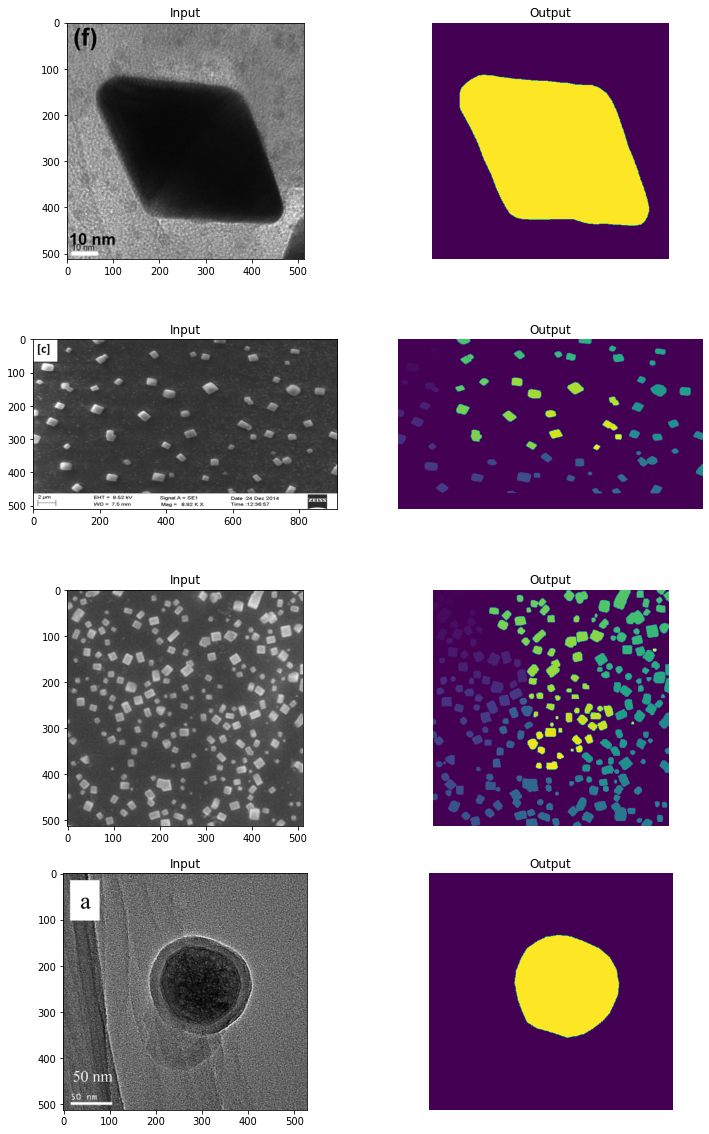

In [ ]:
def display(num_sample):
  plt.figure(figsize=(12, 20))
  image_counter = 0

  samples = sample(images, num_sample)

  for filename in samples:
    image = cv2.imread(f"data/images/{filename}", -1)
    mask = cv2.imread(f"data/segmaps/{filename}", -1)

    plt.subplot(num_sample, 2, image_counter+1)
    plt.title("Input")
    plt.imshow(image)

    plt.subplot(num_sample, 2, image_counter+2)
    plt.title("Output")
    plt.imshow(mask)

    plt.axis('off')

    image_counter += 2

display(4)

# Split data

In [ ]:
splitfolders.ratio("data", output="data", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 930 files [00:00, 2098.06 files/s]


# Agumentation

In [ ]:
class Dataset:
    def __init__(self, images_dir, maps_dir, augmentation = None, preprocessing = None):

        self.img_ids = os.listdir(images_dir)

        self.img_fps = [os.path.join(images_dir, id ) for id in self.img_ids]
        self.map_fps = [os.path.join(maps_dir, id ) for id in self.img_ids]

        self.maps_dir = maps_dir
        self.augmentation = augmentation
        self.preprocessing = preprocessing


    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.img_fps[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (512, 512))

        map = Image.open(os.path.join(self.map_fps[idx]))
        ncols, nrows = map.size
        map = np.array(map.getdata()).reshape((nrows, ncols))
        map = map.astype('float32')
        map = cv2.resize(map, (512, 512))
        map = map.astype('int16')

        if self.augmentation:
            aug_sample = self.augmentation(image = image, mask = map)
            image, map = aug_sample['image'], aug_sample['mask']

        if self.preprocessing:
            processed_sample = self.preprocessing(image = image, mask = map)
            image, map = processed_sample['image'], processed_sample['mask']

        return image, map.astype(np.float32)

    def __len__(self):
        return len(self.img_ids)

In [ ]:
class DataLoader(Sequence):
    def __init__(self, dataset, batch_size = 1, shuffle = False):
        self.indices = np.arange(len(dataset))
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size

        data = []
        for idx in range(start, stop):
            data.append(self.dataset[idx])

        batch = [np.stack(samples, axis = 0) for samples in zip(*data)]

        return batch

    def __len__(self):
        return len(self.indices) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indices = np.random.permutation(self.indices)

In [ ]:
def get_augmentation():

  transforms = [
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.8),
        A.RandomBrightnessContrast(contrast_limit=0.3, brightness_limit=0.3, p=0.2),
        A.OneOf([
              A.ImageCompression(p=0.8),
              A.RandomGamma(p=0.8),
              A.Blur(p=0.8),
          ], p=1.0),
        A.OneOf([
              A.ImageCompression(p=0.8),
              A.RandomGamma(p=0.8),
              A.Blur(p=0.8),
          ], p=1.0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2, border_mode=cv2.BORDER_CONSTANT),
    ]

  return A.Compose(transforms)

def get_preprocessing(preprocessing_fn):
  _transform = [
          A.Lambda(image=preprocessing_fn),
      ]
  return A.Compose(_transform)

def rescalling_image(image, **kwargs):
    return image / 255

Unique valeus in mask: [0. 1. 2. 3. 4. 5. 6. 7.]
Min/Max values of image sample_img min: 0.0, max: 1.0, shape: (512, 512)


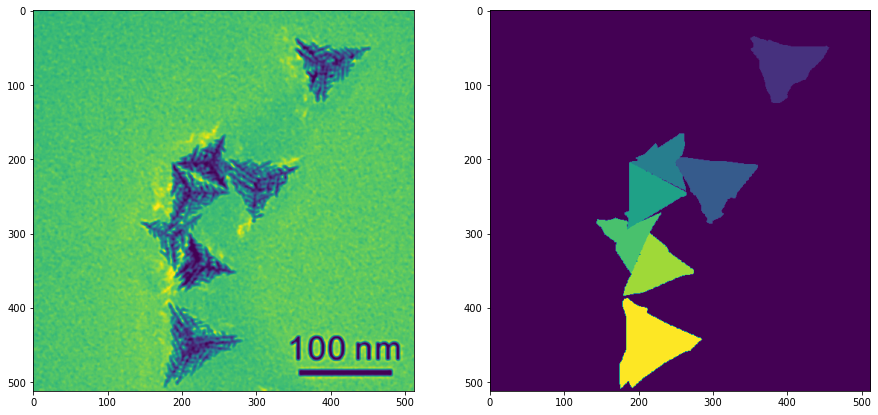

In [ ]:
dataset = Dataset('data/train/images', 'data/train/segmaps', augmentation = get_augmentation(), preprocessing = get_preprocessing(rescalling_image))

sample_img, sample_map = dataset[10]

print(f"Unique valeus in mask: {np.unique(sample_map)}")
print(f"Min/Max values of image sample_img min: {sample_img.min()}, max: {sample_img.max()}, shape: {sample_img.shape}")

fig, ax = plt.subplots(1, 2, figsize = (15,10))

ax[0].imshow(sample_img)
ax[1].imshow(np.squeeze(sample_map))

# Settings

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5

# Load data

In [ ]:
train_dataset = Dataset('data/train/images',
                        'data/train/segmaps',
                        augmentation = get_augmentation(),
                        preprocessing = get_preprocessing(rescalling_image))


valid_dataset = Dataset('data/val/images',
                        'data/val/segmaps',
                        augmentation = get_augmentation(),
                        preprocessing = get_preprocessing(rescalling_image))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [ ]:
from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.data import tfrecord_lib
from official.vision.serving import export_saved_model_lib
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder
from official.vision.utils.object_detection import visualization_utils
from official.vision.ops.preprocess_ops import normalize_image, resize_and_crop_image
from official.vision.data.create_coco_tf_record import coco_annotations_to_lists

model_ckpt_path = './model_ckpt/'
if not os.path.exists(model_ckpt_path):
  os.mkdir(model_ckpt_path)

!gsutil cp gs://tf_model_garden/vision/mobilenet/v2_1.0_float/ckpt-180648.data-00000-of-00001 './model_ckpt/'
!gsutil cp gs://tf_model_garden/vision/mobilenet/v2_1.0_float/ckpt-180648.index './model_ckpt/'

exp_config = exp_factory.get_exp_config('maskrcnn_mobilenet_coco')

Copying gs://tf_model_garden/vision/mobilenet/v2_1.0_float/ckpt-180648.data-00000-of-00001...
/ [1 files][ 26.9 MiB/ 26.9 MiB]                                                
Operation completed over 1 objects/26.9 MiB.                                     
Copying gs://tf_model_garden/vision/mobilenet/v2_1.0_float/ckpt-180648.index...
/ [1 files][  7.5 KiB/  7.5 KiB]                                                
Operation completed over 1 objects/7.5 KiB.                                      


In [ ]:
# Backbone Config
exp_config.task.annotation_file = None
exp_config.task.freeze_backbone = True
exp_config.task.init_checkpoint = "./model_ckpt/ckpt-180648"
exp_config.task.init_checkpoint_modules = "backbone"

In [ ]:
# Model Config
exp_config.task.model.num_classes = 2
exp_config.task.model.input_size = [512, 512, 3]

In [ ]:
# Training Data Config
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = BATCH_SIZE
exp_config.task.train_data.shuffle_buffer_size = 64
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0

# Metrics

In [ ]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 1)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Model

In [ ]:
def build_model(input_shape):
    inputs = Input(input_shape)

    # Encoding

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    # Bottom Layers

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    # Decoding

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = Concatenate()([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = Concatenate()([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = Concatenate(axis=3)([u9, c1])
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', )

    return model

model = build_model((512, 512, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 256, 8)  0           ['conv2d_1[0][0]']           

# Callbacks

In [ ]:
dt = datetime.now().strftime('%d_%m_%Y_%H_%M')
filepath = os.path.join('output', 'model_' + dt + '.hdf5')
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_mean_iou', save_best_only=True)

# Fit model

In [ ]:
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    #callbacks=[checkpoint],
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
)

In [ ]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)